# Error Analysis & Model Explainability

In [ ]:
!nvidia-smi

Thu Jun 13 18:37:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#@title ## Getting data & Definition of the data processing function
!git clone https://github.com/shuuchuu/dataset-landscape.git
!pip install shap
import itertools
import os
import pathlib
import random
import typing

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas
import PIL
import seaborn
import shap
import skimage.transform
import sklearn.utils
import sklearn.metrics
import tensorflow as tf
import tensorflow.keras as keras
import tqdm.notebook


INPUT_SHAPE = (150, 150)


label_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
label_to_index = {l: i for i, l in enumerate(label_names)}


def get_images(dir_path: pathlib.Path,
               shuffle: bool = True,
               create_labels: bool = True,
               ) -> typing.Tuple[tf.Tensor, tf.Tensor]:
  images = []
  if create_labels:
    labels = []

  for subdir_path in tqdm.notebook.tqdm(
      list(dir_path.iterdir()), desc="Folders processing"):

    dir_name = subdir_path.name

    if create_labels:
      label = label_to_index.get(dir_name)

    for image_path in tqdm.notebook.tqdm(
        list(subdir_path.iterdir()), desc=f"Folder {dir_name}", leave=False):
      images.append(
          numpy.array(PIL.Image.open(image_path).resize(INPUT_SHAPE)))
      if create_labels:
        labels.append(label)

  images = tf.constant(numpy.array(images))
  if create_labels:
    labels = tf.constant(numpy.array(labels))

  if shuffle:
    perm = tf.random.shuffle(tf.range(images.shape[0]))
    images = tf.gather(images, perm)
    if create_labels:
      labels = tf.gather(labels, perm)

  if create_labels:
    return images, labels
  else:
    return images

Cloning into 'dataset-landscape'...
remote: Enumerating objects: 24310, done.
remote: Total 24310 (delta 0), reused 0 (delta 0), pack-reused 24310
Receiving objects: 100% (24310/24310), 342.22 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (24337/24337), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
images, labels = get_images(pathlib.Path("dataset-landscape") / "seg_train")

Folders processing:   0%|          | 0/6 [00:00<?, ?it/s]

Folder sea:   0%|          | 0/2274 [00:00<?, ?it/s]

Folder street:   0%|          | 0/2382 [00:00<?, ?it/s]

Folder glacier:   0%|          | 0/2404 [00:00<?, ?it/s]

Folder forest:   0%|          | 0/2271 [00:00<?, ?it/s]

Folder mountain:   0%|          | 0/2512 [00:00<?, ?it/s]

Folder buildings:   0%|          | 0/2191 [00:00<?, ?it/s]

## Finetuning a model

In [ ]:
#@title Definition of a model
base_model = keras.applications.EfficientNetB0(include_top=False,
                                               weights="imagenet",
                                               input_shape=(150, 150, 3))

base_model.trainable = False

transferred_cnn = keras.Sequential(
    [base_model,
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(1024, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(256, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(64, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(16, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Flatten(),
     keras.layers.Dense(6, activation="softmax", kernel_regularizer="l2")],
    name="transferred_cnn")

transferred_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

transferred_cnn.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "transferred_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 spatial_dropout2d (Spatial  (None, 5, 5, 1280)        0         
 Dropout2D)                                                      
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 1024)        1311744   
                                                                 
 spatial_dropout2d_1 (Spati  (None, 5, 5, 1024)        0         
 alDropout2D)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 256)      

In [ ]:
training = transferred_cnn.fit(images,
                               labels,
                               epochs=5,
                               validation_split=0.30,
                               batch_size=512)

Epoch 1/5
20/20 [==============================] - 55s 2s/step - loss: 1.6119 - accuracy: 0.4175 - val_loss: 1.0883 - val_accuracy: 0.7136
Epoch 2/5
20/20 [==============================] - 11s 580ms/step - loss: 0.9766 - accuracy: 0.6951 - val_loss: 0.6102 - val_accuracy: 0.8466
Epoch 3/5
20/20 [==============================] - 13s 676ms/step - loss: 0.6649 - accuracy: 0.8069 - val_loss: 0.4518 - val_accuracy: 0.8874
Epoch 4/5
20/20 [==============================] - 13s 677ms/step - loss: 0.5504 - accuracy: 0.8459 - val_loss: 0.3937 - val_accuracy: 0.9076
Epoch 5/5
20/20 [==============================] - 11s 582ms/step - loss: 0.4802 - accuracy: 0.8676 - val_loss: 0.3676 - val_accuracy: 0.9105


## Error analysis

In [ ]:
#@title Definition of an error analysis function
test_images,test_labels = get_images(
    pathlib.Path("dataset-landscape") / "seg_test")


def predict(model: keras.Model, images: tf.Tensor) -> tf.Tensor:
  return tf.math.argmax(model.predict(images), axis=-1)


def analyze_preds(preds: tf.Tensor, labels: tf.Tensor) -> None:
  confusion_matrix = sklearn.metrics.confusion_matrix(labels, preds)
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names,
                  annot=True,
                  fmt="d")
  plt.title("Confusion matrix")
  plt.show()

  seaborn.countplot(x=[label_names[x] for x in preds])
  plt.title("Predicted classes count")
  plt.ylabel("Count")
  plt.xlabel("Class")
  plt.show()


def plot_mistakes(predicted_class: str,
                  true_class: str,
                  images: tf.Tensor,
                  preds: tf.Tensor,
                  labels: tf.Tensor
                  ) -> None:
  print(f"Predicted: {predicted_class}, real : {true_class}")
  mistakes = images[(preds == label_to_index[predicted_class])
                         & (labels == label_to_index[true_class])]
  random_indexes = numpy.random.choice(mistakes.shape[0],
                                       size=min(mistakes.shape[0], 25),
                                       replace=False)
  grid_indexes = itertools.product(range(5), repeat=2)

  if mistakes.shape[1] == 3:
    mistakes = tf.transpose(mistakes, perm=(0, 2, 3, 1))

  _, ax = plt.subplots(5, 5, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()


def evaluate(model: keras.Model, images: tf.Tensor, labels: tf.Tensor) -> None:
  loss, accuracy = model.evaluate(images, labels, verbose=False)
  print(f"Loss: {loss:.2f}, accuracy: {accuracy:.2f}")
  preds = predict(model, images)
  analyze_preds(preds, labels)
  plot_mistakes("glacier", "mountain", images, preds, labels)
  plot_mistakes("glacier", "sea", images, preds, labels)
  plot_mistakes("buildings", "sea", images, preds, labels)

Folders processing:   0%|          | 0/6 [00:00<?, ?it/s]

Folder sea:   0%|          | 0/510 [00:00<?, ?it/s]

Folder street:   0%|          | 0/501 [00:00<?, ?it/s]

Folder glacier:   0%|          | 0/553 [00:00<?, ?it/s]

Folder forest:   0%|          | 0/474 [00:00<?, ?it/s]

Folder mountain:   0%|          | 0/525 [00:00<?, ?it/s]

Folder buildings:   0%|          | 0/437 [00:00<?, ?it/s]

Loss: 0.40, accuracy: 0.90
94/94 [==============================] - 4s 30ms/step


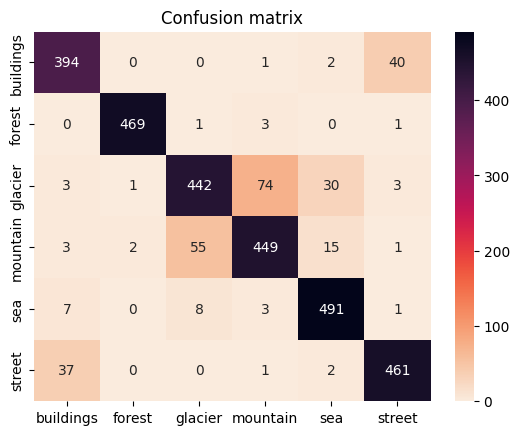

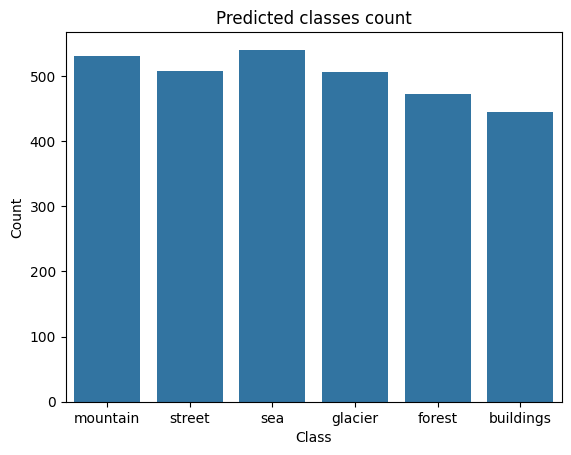

Predicted: glacier, real : mountain


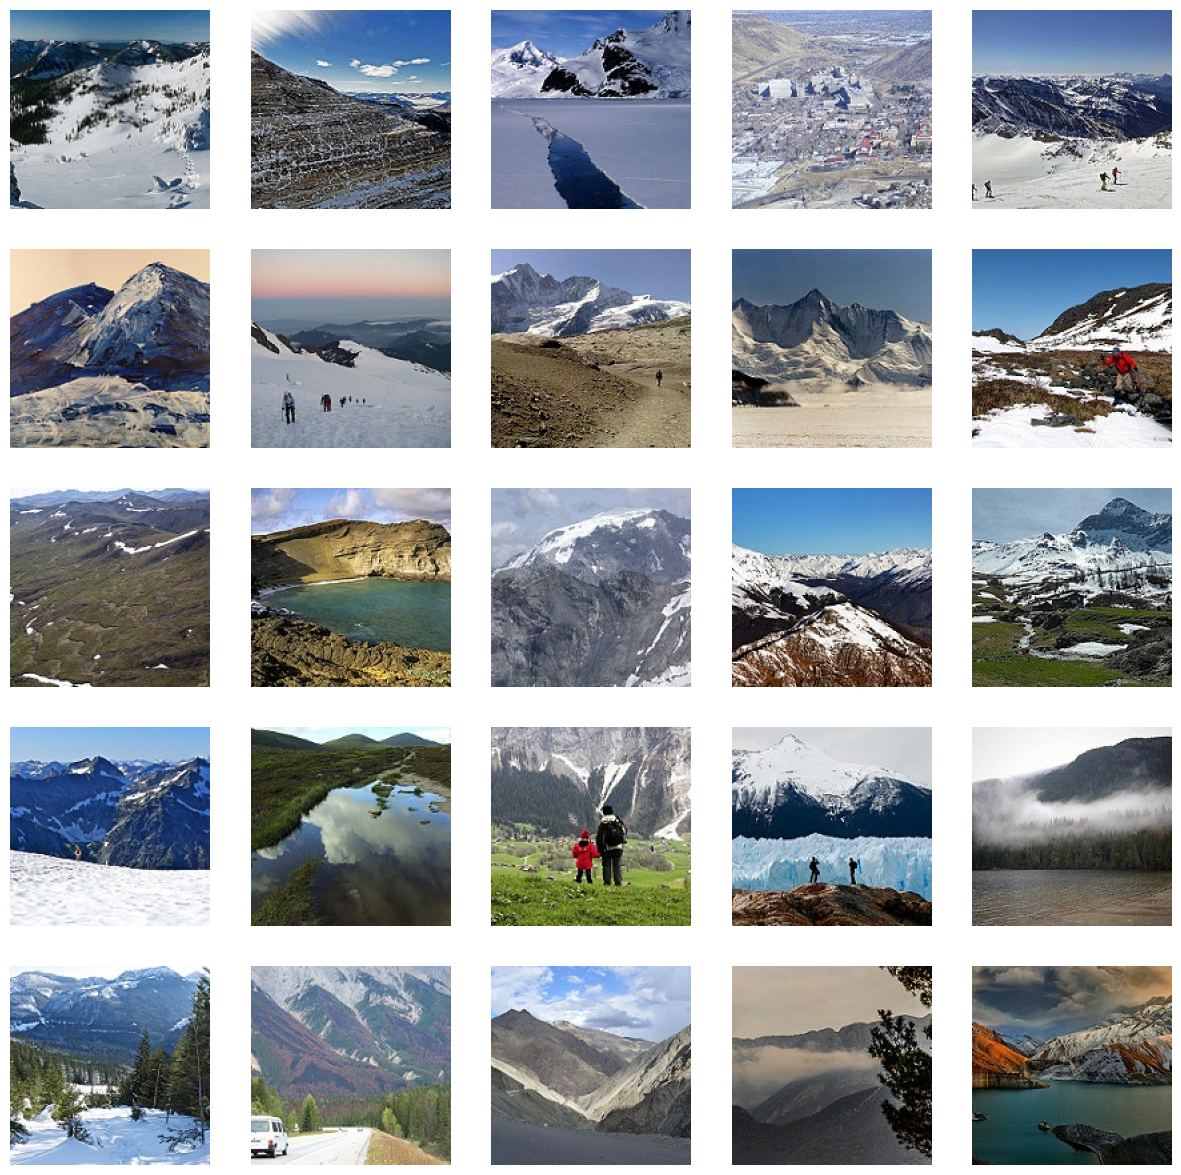

Predicted: glacier, real : sea


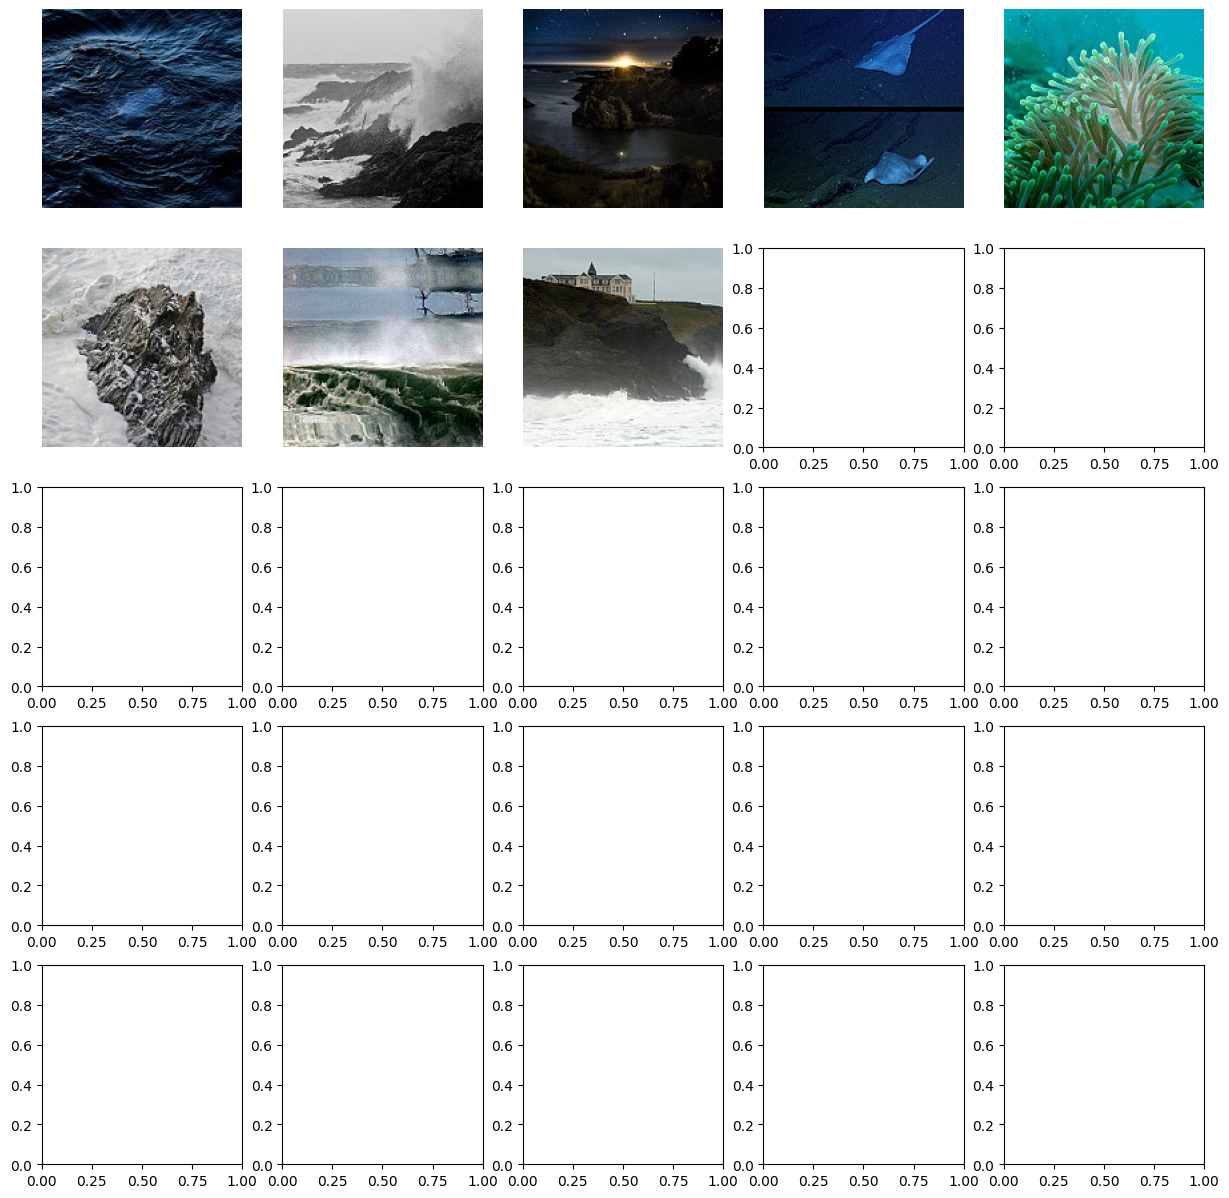

Predicted: buildings, real : sea


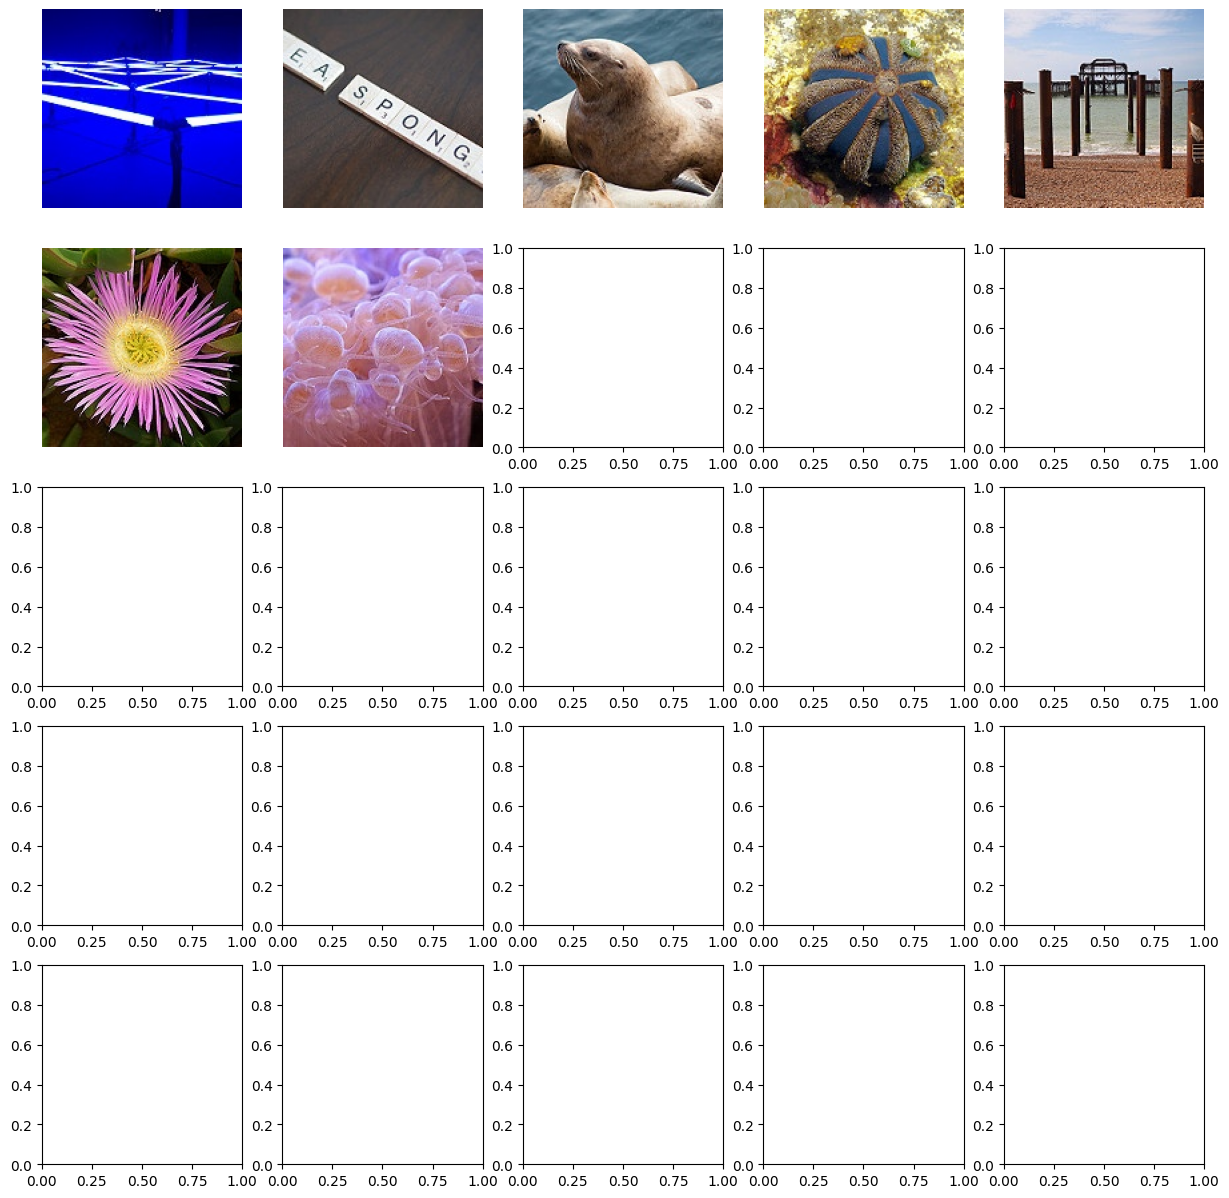

In [ ]:
evaluate(transferred_cnn, test_images, test_labels)

## Model interpretability with SHAP

Use the `shap` library to interpret the model predictions on the first 10 images of the training dataset.

In [ ]:
!pip install shap

In [ ]:
# Your code here

### Solution

In [ ]:
import shap

masker = shap.maskers.Image("blur(32,32)", images[0].shape)

explainer = shap.Explainer(transferred_cnn.predict, masker, output_names=label_names)

shap_values = explainer(
    images[:10].numpy(), max_evals=1_000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)

2/2 [==============================] - 0s 29ms/step


  0%|          | 0/998 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


PartitionExplainer explainer:  30%|███       | 3/10 [00:15<00:14,  2.06s/it]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer:  40%|████      | 4/10 [00:19<00:15,  2.64s/it]

2/2 [==============================] - 0s 41ms/step


In [ ]:
shap.image_plot(shap_values)

## SHAP on structured data

Let's retrieve some structured data and train a model:

In [ ]:
#@title Getting and processing structured data
!git clone https://github.com/nzmonzmp/dataset-ames.git
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import sklearn.ensemble
import sklearn.model_selection
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

def preprocess(train_file, test_file):
    train_X = pandas.read_csv(train_file, index_col="Id")
    test_X = pandas.read_csv(test_file, index_col="Id")

    train_y = train_X.pop("SalePrice")

    all_X = pandas.concat([train_X, test_X])

    # Fill with median
    cols_1 = ["LotFrontage"]
    all_X[cols_1] = all_X[cols_1].fillna(train_X[cols_1].median())

    # Fill with mode
    cols_2 = ["MSZoning", "Electrical", "KitchenQual", "Exterior1st",
             "Exterior2nd", "SaleType", "Utilities"]
    all_X[cols_2] = all_X[cols_2].fillna(train_X[cols_2].mode().iloc[0, :])

    # Fill with 0
    cols_4 = ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1",
              "BsmtFinSF2", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF",
              "MasVnrArea", "TotalBsmtSF"]
    all_X[cols_4] = all_X[cols_4].fillna(0)

    # Other fills
    cols_5 = ["Functional"]
    all_X[cols_5] = all_X[cols_5].fillna("Typ")

    all_X = all_X.fillna("NA")

    cols_numerical2label = ['MSSubClass']
    all_X[cols_numerical2label] = all_X[cols_numerical2label].astype(str)

    quality_mapping = dict(NA=0, Po=1, Fa=2, TA=3, Gd=4, Ex=5)
    quality_columns = ["BsmtCond", "BsmtQual", "ExterCond", "ExterQual",
                       "FireplaceQu", "GarageCond", "GarageQual", "HeatingQC",
                       "KitchenQual", "PoolQC"]
    street_mapping = dict(NA=0, Grvl=1, Pave=2)
    bsmt_fin_mapping = dict(NA=0, Unf=1, LwQ=2, Rec=3, BLQ=4, ALQ=5, GLQ=6)

    replace_mapping = dict(
      Alley=street_mapping,
      BsmtExposure=dict(NA=0, No=1, Mn=2, Av=3, Gd=4),
      BsmtFinType1=bsmt_fin_mapping,
      BsmtFinType2=bsmt_fin_mapping,
      Functional=dict(Sal=1, Sev=2, Maj2=3, Maj1=4, Mod=5, Min2=6, Min1=7, Typ=8),
      LandSlope=dict(Sev=1, Mod=2, Gtl=3),
      LotShape=dict(IR3=1, IR2=2, IR1=3, Reg=4),
      PavedDrive=dict(NA=0, N=1, P=2, Y=3),
      Street=dict(Grvl=1, Pave=2),
      Utilities=dict(ELO=1, NoSeWa=2, NoSewr=3, AllPub=4),
    )

    for quality_column in quality_columns:
      replace_mapping[quality_column] = quality_mapping

    all_X.replace(replace_mapping, inplace=True)

    print(f"Number of NAs : {all_X.isnull().sum().sum()}")

    dummies = pandas.get_dummies(all_X)
    return (dummies.iloc[:train_X.shape[0], :],
            train_y,
            dummies.iloc[train_X.shape[0]:, :])

In [ ]:
X, y, _ = preprocess("dataset-ames/train.csv", "dataset-ames/test.csv")

In [ ]:
rfr = sklearn.ensemble.RandomForestRegressor()
rfr.fit(X, y)

## Global explanation

Explain the marginal gain from each feature on the training dataset using `shap`.

In [ ]:
# Your code here

### Solution

In [ ]:
explainer = shap.TreeExplainer(rfr)
explanation = explainer(X)
shap.plots.bar(explanation)

## Local explanation

Now explain the prediciton of the model for the first data point.

In [ ]:
# Your code here

### Solution

In [ ]:
X.head(1)

In [ ]:
shap.plots.bar(explanation[0])